In [1]:
from power_planner.utils import get_donut_vals, get_half_donut, get_distance_surface, bresenham_line, rescale, get_lg_donut, angle, normalize
from power_planner.plotting import plot_path, plot_path_costs
from power_planner.constraints import ConstraintUtils
import numpy as np
from graph_tool.all import Graph, shortest_path,load_graph, find_edge, remove_labeled_edges
import matplotlib.pyplot as plt
import os
import pickle

In [2]:
instance_path = "/Users/ninawiedemann/Downloads/tifs_new/data_dump_5.dat"
with open(instance_path, "rb") as infile:
    data = pickle.load(infile)
(instance, instance_corr, start_inds, dest_inds) = data.data

In [3]:
FACTOR_ALL = 1
test_example = rescale(np.sum(instance, 0), FACTOR_ALL)

<function matplotlib.pyplot.show(*args, **kw)>

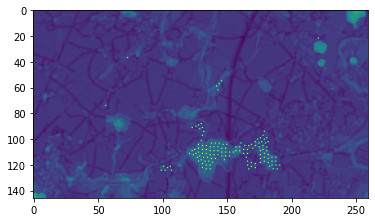

In [4]:
plt.imshow(test_example)
plt.show

In [5]:
min_dist = 3
max_dist = 5
weights = [0.5,0.5]
start_inds = start_inds//FACTOR_ALL
dest_inds = dest_inds//FACTOR_ALL
test_example = normalize(test_example)+0.1

In [6]:
shifts = get_half_donut(3,5, dest_inds-start_inds, angle_max = 0.5*np.pi)

In [24]:
def shift_surface(costs, shift, fill_val = np.inf):
    """
    Shifts a numpy array and pads with zeros
    :param costs: 2-dim numpy array
    :param shift: tuple of shift in x and y direction
    BUT: ONLY WORKS FOR (+,+) or (+,-) shift tuples
    :returns shifted array of same size
    """
    rolled_costs = np.roll(costs, shift, axis=(0, 1))
    if shift[0] >= 0:
        rolled_costs[:shift[0], :] = fill_val
    else:
        rolled_costs[shift[0]:, :] = fill_val
    if shift[1] >= 0:
        rolled_costs[:, :shift[1]] = fill_val
    else:
        rolled_costs[:, shift[1]:] = fill_val
    return rolled_costs

def compute_angles_manually(path):
    ang_out = [0]
    for p in range(len(path)-2):
        vec1 = path[p+1]-path[p]
        vec2 = path[p+2]-path[p+1]
        print( path[p+2],  path[p+1])
        ang_out.append(round(angle(vec1, vec2)/(3*np.pi/4), 2))
        print(ang_out[-1])
    ang_out.append(0)
    return ang_out

[2, 3]
0.21041657583943443
[3, 1]
0.0
[3, 2]
0.08475065946143202
[3, 3]
0.1475836176504332
[3, 4]
0.1927508529512998
[4, 2]
0.04516723530086645
[4, 3]
0.10241638234956665


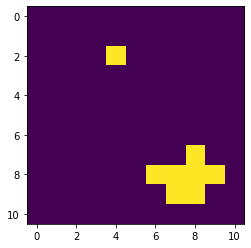

In [142]:
a = np.zeros((11,11))
for p in don_lis:
    if np.all(p[0]==[-3, -1]):
        print(p[1])
        i,j = p[1]
        print(angle(np.array(p[0])*(-1), p[1])/np.pi)
        a[i+5,j+5] = 1
        k,l = p[0]
        a[k+5,l+5] = 1
plt.imshow(a)
plt.show()

In [132]:
don_lis = get_lg_donut(3,5,dest_inds-start_inds, min_angle=np.pi/4)

In [119]:
def compute_dists(n_iters, shifts, test_example, start_inds, dest_inds, weights = [0.5, 1]):
    # weights = [0.5,0.5]
    min_angle= 1 * np.pi / 4 # TODO

    fill_val = np.inf
    # one iteration
    # for i in range(len(shifts)):
    x_len, y_len = test_example.shape
    angle_weight, resistance_weight = tuple(np.array(weights)/np.sum(weights))
    print(angle_weight, resistance_weight)
    dists = np.zeros((len(shifts), x_len, y_len))
    dists += fill_val
    dists[:, start_inds[0], start_inds[1]] = test_example[start_inds[0], start_inds[1]]
    dists_argmin = np.zeros(dists.shape)
    # precompute angles
    angles_all = np.zeros((len(shifts), len(shifts)))
    for i in range(len(shifts)):
        angles_all[i] = [angle(s, shifts[i]) for s in shifts]
    angles_all = angles_all/min_angle
    angles_all[angles_all>1] = np.inf

    for j in range(n_iters):
        for i in range(len(shifts)): # 10,11): # 
            # i = 10
            # compute angle from the sorted neighbor list to the new edge
            # immer plus das minimum
            curr_shift = shifts[i]

            angles = angles_all[i]
            # shift dists by this shift
            # todo: avoid swaping dimenions each time
            cost_switched = np.moveaxis(dists, 0, -1)
            # shift by shift
            costs_shifted = shift_surface(
                cost_switched, curr_shift
            )
            # costs_shifted[costs_shifted==0] = fill_val

            # POSSIBLE BUT not necessary!
            # test_shifted = shift_surface(
            #     test_example.copy(), curr_shift, fill_val=0
            # )
            # norm_angle = angles/min_angle # np.max(angles)
            # norm_angle[norm_angle>min_angle] = np.inf
            # norm_angle>1 --> np.inf
            
            # costs_shifted = np.moveaxis(costs_shifted, -1, 0)
            together = np.zeros(costs_shifted.shape)
            # for k in range(len(shifts)):
            #     for l in range(x_len):
            #         for m in range(y_len):
            #             together[k,l,m] = costs_shifted[k,l,m] + angles[k] * angle_weight + test_example[l,m]* resistance_weight
                        
            angle_cost = angle_weight *  angles
            together = np.moveaxis(costs_shifted + angle_cost, -1, 0) + test_example * resistance_weight
            # 28 x 10 x 10 + 28 angles + 10 x 10
            
            weighted_costs_shifted = np.min(together, axis=0)
            
            # if j==8 and i==16:
            #     print(angle_cost)
            #     print(np.argmin(together, axis=0)[16,70])
            #     print(weighted_costs_shifted[16, 70])
            # 

            concat = np.array([dists[i], weighted_costs_shifted])
            
            # temp = dists_argmin[i]
            # print(temp.shape)
            # get spots that are actually updated
            changed_ones = np.argmin(concat, axis=0)
            # get argmin for each edge --> remember where the value on this edge came from
            argmin_together = np.argmin(together, axis=0)
            ## FOR LOOP SOLUTION
            # for m in range(len(temp)):
            #     for n in range(len(temp[0])):
            #         if changed_ones[m,n]:
            #             dists_argmin[i,m,n] = argmin_together[m,n]
            ## TEMP SOLUTION:
            # temp[changed_ones>0] = argmin_together[changed_ones>0]
            # dists_argmin[i] = temp
            dists_argmin[i, changed_ones>0] = argmin_together[changed_ones>0]

            dists[i] = np.min(concat, axis=0)
            # print("-------------")
    assert(np.all(dists_argmin<np.inf))
    print("opt", np.min(dists[:, dest_inds[0], dest_inds[1]]))
    
    return dists, dists_argmin

def get_path_from_dists(dists, dists_argmin, test_example):
    if not np.any(dists[:, dest_inds[0], dest_inds[1]] < np.inf):
        raise RuntimeWarning("empty path")
        return [], []
    curr_point = dest_inds
    my_path = [dest_inds]
    path_costs = [test_example[dest_inds[0], dest_inds[1]]]
    # print(test_example[dest_inds[0], dest_inds[1]])
    min_shift = np.argmin(dists[:, dest_inds[0], dest_inds[1]])
    while np.any(curr_point - start_inds):
        # min_dist = np.argmin(dists[:, curr_point[0], curr_point[1]])
        new_point = curr_point - shifts[int(min_shift)]
        min_shift = dists_argmin[int(min_shift), curr_point[0], curr_point[1]]
        # print(new_point)
        # print(test_example[new_point[0], new_point[1]])
        path_costs.append(test_example[new_point[0], new_point[1]])
        my_path.append(new_point)
        curr_point = new_point
    return my_path, path_costs

# def my_path_computation(n_iters, shifts, test_example, start_inds, dest_inds, weights = [0.5, 1]):
dists, dists_argmin = compute_dists(50, shifts, example2, start_inds, dest_inds, weights = [0.5,0.5])
# plt.imshow(np.min(dists, axis=0))
# plt.colorbar()
# plt.show()
my_path, path_costs = get_path_from_dists(dists, dists_argmin, test_example)
my_path = np.flip(np.asarray(my_path), axis=0) # # np.flip(np.array(my_path), axis=0)
my_path_costs = np.flip(np.asarray(path_costs), axis=0) # np.flip(np.array(path_costs), axis=0)
# return my_path, my_path_costs

0.5 0.5
opt inf


RuntimeWarning: empty path

In [144]:
170000*310000

52700000000

In [73]:
# unit tests
example2 = np.zeros(test_example.shape)
example2 += np.inf
line = bresenham_line(start_inds[0], start_inds[1], dest_inds[0], dest_inds[1])
for (i,j) in line:
    example2[i,j] = 1
# get out thing, check that nonempty and corresponding 

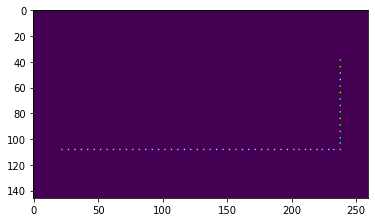

In [118]:
out = np.zeros(test_example.shape)
for (i,j) in my_path:
    out[i,j] = 1
plt.imshow(out)
plt.show()

In [125]:
angle([-1,0], [1,1])/np.pi

0.75

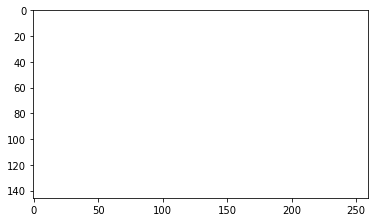

In [110]:
# unit test2: with 90 grad winkel --> not supposed to work with max_angle 3/4, only with 1/4
example2 = np.zeros(test_example.shape)
example2 += np.inf
example2[start_inds[0], start_inds[1]:dest_inds[1]-3] = 1
example2[start_inds[0], dest_inds[1]] = 1
example2[dest_inds[0]:start_inds[0]-3, dest_inds[1]] = 1
plt.imshow(example2)
plt.show()

In [116]:
example2[start_inds[0], dest_inds[1]]

1.0

### Most important testing function to check whether it is correct

In [197]:
shift_dict = {tuple(shifts[i]):i for i in range(len(shifts))}
prev = start_inds
c = test_example[start_inds[0], start_inds[1]] - 0.3918232239145548 # first angle is wrong --> subtract
path = my_path
for p in range(1, len(path)):
    i,j = path[p] # current node
    shift = path[p] - prev # incoming edge index to the current node --> should have accumulated cost of prev one 
    shift_ind = shift_dict[tuple(shift)]
    prev = path[p]
    ang = 0.3 * angle(path[p]-path[p-1], path[p-1]-path[p-2])/(3*np.pi/4)
    cost = 0.7 * test_example[i,j]
    print(round(dists[shift_ind, i,j], 5), "actual",  round(c + ang + cost, 5))
    # print(shift_ind, i,j)
    # print(ang)
    c += ang + cost

0.42782 actual 0.39663
0.60866 actual 0.57747
0.82543 actual 0.79423
0.99783 actual 0.96664
1.13894 actual 1.10775
1.3819 actual 1.35071
1.57799 actual 1.5468
1.82303 actual 1.79184
1.98946 actual 1.95827
2.14673 actual 2.11554
2.3655 actual 2.33431
2.54092 actual 2.50973
2.72949 actual 2.6983
2.96231 actual 2.93112
3.13146 actual 3.10027
3.38632 actual 3.35513
3.77599 actual 3.71582


## Compare to line graph

In [11]:
from power_planner.graphs import *

In [12]:
def run_on_lg(test_example, start_inds, dest_inds, cost_weights):
    instance_corr = np.zeros(test_example.shape)
    instance_corr[dest_inds[0]:start_inds[0]+1, start_inds[1]:dest_inds[1]+1] = 1
    # plt.imshow(instance_corr)
    # plt.colorbar()
    # plt.show()
    graph = LineGraph(
        np.array([test_example]), instance_corr, graphtool=1, verbose=1
    )
    graph.set_edge_costs(["resistance"], cost_weights) # [0.4,1])
    graph.set_shift(min_dist, max_dist, dest_inds-start_inds, 0.5 * np.pi)
    # add vertices
    graph.add_nodes()
    corridor = np.ones(instance_corr.shape) * 0.5  # start with all
    graph.set_corridor(1, corridor, start_inds, dest_inds)
    print("1) set cost rest")
    graph.add_edges()
    print("2) added edges", len(list(graph.graph.edges())))
    print("number of vertices:", len(list(graph.graph.vertices())))

    # weighted sum of all costs
    graph.sum_costs()
    source_v, target_v = graph.add_start_and_dest(start_inds, dest_inds)
    path, path_costs, cost_sum = graph.get_shortest_path(source_v, target_v)
    return np.array(path), np.array(path_costs)

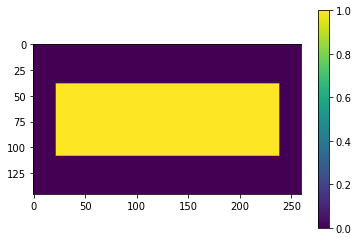

edge costs classes: ['angle', 'resistance']
['angle', 'resistance'] [0.5 0.5]
Added nodes: 1062880 in time: 0.07856202125549316
1) set cost rest
n_neighbors: 740
Done adding edges: 10291400
DONE adding 10291400 edges: 13.047585010528564
2) added edges 10291400
number of vertices: 1062880
mean costs: [0, 0.2659016291107435]


In [33]:
path, path_costs = run_on_lg(test_example, start_inds, dest_inds, [0.5,0.5])

### Plot both paths

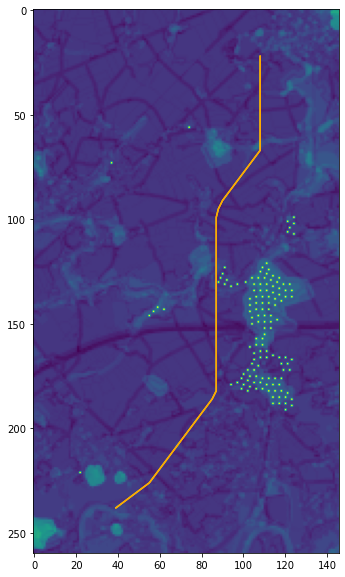

In [52]:
path = np.array(path)
my_path = np.array(my_path)
plt.figure(figsize=(20,10))
plt.imshow(np.swapaxes(test_example,1,0))
plt.plot(path[:,0], path[:,1],color="yellow")
plt.plot(my_path[:,0], my_path[:,1], color="orange")
plt.show()

### Compare costs

In [35]:
rev_len = len(my_path)
angs = compute_angles_manually(path)
my_angs = compute_angles_manually(my_path)
for p in range(len(path)):
    print(path[p], my_path[p])
    # print(test_example[my_path[p][0], my_path[p][1]])
    i,j = tuple(my_path[p])
    k,l = tuple(path[p])
    print(test_example[k,l], my_path_costs[p], round(test_example[i,j],2), angs[p], my_angs[p])
    # print(round(path_costs[p][1],2), round(test_example[i,j], 2))

[108  32] [108  27]
0.0
[108  37] [108  32]
0.0
[108  42] [108  37]
0.0
[108  47] [108  42]
0.0
[108  52] [108  47]
0.0
[108  57] [108  52]
0.0
[108  62] [108  57]
0.0
[108  67] [108  62]
0.0
[105  71] [108  67]
0.27
[102  75] [105  71]
0.0
[99 79] [102  75]
0.0
[96 83] [99 79]
0.0
[93 87] [96 83]
0.0
[90 91] [93 87]
0.0
[88 95] [90 91]
0.08
[87 99] [88 95]
0.09
[ 87 104] [87 99]
0.1
[ 87 108] [ 87 104]
0.0
[ 87 113] [ 87 108]
0.0
[ 87 118] [ 87 113]
0.0
[ 87 123] [ 87 118]
0.0
[ 87 128] [ 87 123]
0.0
[ 87 132] [ 87 128]
0.0
[ 87 137] [ 87 132]
0.0
[ 87 142] [ 87 137]
0.0
[ 87 147] [ 87 142]
0.0
[ 87 152] [ 87 147]
0.0
[ 87 157] [ 87 152]
0.0
[ 87 162] [ 87 157]
0.0
[ 87 167] [ 87 162]
0.0
[ 87 172] [ 87 167]
0.0
[ 87 177] [ 87 172]
0.0
[ 87 182] [ 87 177]
0.0
[ 85 186] [ 87 182]
0.2
[ 82 190] [ 85 186]
0.08
[ 79 194] [ 82 190]
0.0
[ 76 198] [ 79 194]
0.0
[ 73 202] [ 76 198]
0.0
[ 70 206] [ 73 202]
0.0
[ 67 210] [ 70 206]
0.0
[ 64 214] [ 67 210]
0.0
[ 61 218] [ 64 214]
0.0
[ 58 222] [ 

In [36]:
print(np.sum(path_costs[1:-1,1]), np.sum(my_path_costs[1:-1]))

10.768594200683847 10.768594200683847


In [37]:
print(np.sum(angs), np.sum(my_angs))

0.94 0.94


In [39]:
print(0.5*np.sum(angs)+ 0.5*np.sum(path_costs[:,1]), 0.5*np.sum(my_angs)+ 0.5*np.sum(my_path_costs))

6.1201987294526665 6.096515892584333


In [26]:
len(my_path), len(path)

(50, 50)

## Random shit

In [212]:
%timeit 2*2


12.1 ns ± 0.0427 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [ ]:
# old versions from package
    def get_path_from_dists(self, start_inds, dest_inds):
        curr_point = dest_inds
        path = [dest_inds]
        path_costs = [self.instance[dest_inds[0], dest_inds[1]]]
        # print(test_example[dest_inds[0], dest_inds[1]])
        while np.any(curr_point - start_inds):
            min_shift = np.argmin(self.dists[:, curr_point[0], curr_point[1]])
            new_point = curr_point - self.shifts[min_shift]
            path.append(new_point)
            # print(new_point)
            # print(test_example[new_point[0], new_point[1]])
            path_costs.append(self.instance[new_point[0], new_point[1]])
            curr_point = new_point
        path.append(curr_point)

        path = np.flip(np.asarray(path), axis=0)
        path_costs = np.flip(np.asarray(path_costs), axis=0)

        return path, path_costs

In [ ]:
# Test functions for correctness
# FUNCTION 1
path = my_path
costs_start = test_example[start_inds[0],start_inds[1]]
for p in range(len(path)-2):
    (i,j) = path[p]
    k,l = path[p+1]
    print(i,j)
    # print(dists[:, i,j])
    print(round(np.min(dists[:, i,j]),3))
    print("angle", 0.5* angle(path[p+1]-path[p], path[p+2]-path[p+1])/(3*np.pi/4))
    print("costs", round(0.5* test_example[k,l],2))
    costs_start += 0.5* test_example[k,l] + 0.5* angle(path[p+1]-path[p], path[p+2]-path[p+1])/(3*np.pi/4)
    print(round(costs_start,2))
    print("-----------")
    
# FUNCTION 2 
curr_point = dest_inds
some_path = [dest_inds]
count = len(path)-2
# print(test_example[dest_inds[0], dest_inds[1]])
while np.any(curr_point - start_inds):
    # print(dists[:, curr_point[0], curr_point[1]])
    min_shift = np.argmin(dists[:, curr_point[0], curr_point[1]])
    new_point = curr_point - shifts[min_shift]
    print("--------------------")
    print(curr_point)
    print(np.min(dists[:, curr_point[0], curr_point[1]]))
    print("shift", shifts[min_shift])
    some_path.append(new_point)
    
    i,j = curr_point
    print("costs currpoint", test_example[i,j]*0.5)
    curr_point = new_point
    if np.any(curr_point!=path[count]):
        print(path[count])
    count-= 1
    k,l = path[count]
    # print("costs actual", test_example[k,l]*0.5)